![LogoTec](img/logoTec.png)

# TC 5033
## Advanced Machine Learning
## José Antonio Cantoral Ceballos, Ph.D.

## Team Members:
- A01200230 - Armando Bringas Corpus
- A01793102 - Carlos Enriquez Gorgonio
- A00947315 - Manuel ?


#### Activity 1a: Implementing a Multilayer Fully Connected Network using Numpy
#### Non-graded activity (0 points)

- Objective

The primary objective of this activity is to deepen your understanding of Fully Connected Networks by implementing a multilayer network using only Numpy. You  are  given  the follosing starter code that solves the MNIST dataset problem. Your task is to read, understand, and then apply this knowledge to solve classification problems on other datasets such as the Kaggle ASL dataset (Starter code will be provided separately for that activity).

- Instructions

    Read and Understand the following Code: The provided starter code outlines the architecture of a Fully Connected Network designed to classify MNIST images. Go through the code to understand how each function and class is used to implement the network.

    Understand the Math: Make sure you understand the math operations implemented in the code, especially during the forward and backward passes. This will involve matrix multiplications, activation functions, loss computations, and backpropagation.
    
- Experiment
    You are encouraged to play with the code, change any hyperparameters and train the model, you should be able to achieve over 95% accuracy on the test set without problems.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Import Images

In [2]:
from get_images import get_images

In [3]:
# MNIST path
mnist_path = 'data/mnist_raw/'
x_train_num, y_train_num, x_test_num, y_test_num = get_images(mnist_path)

x_train = x_train_num[:50000].reshape(50000, -1).astype(float)
y_train = y_train_num[:50000].reshape(50000, 1)

x_val = x_train_num[50000:].reshape(10000, -1).astype(float)
y_val = y_train_num[50000:].reshape(10000, 1)

x_test = x_test_num.copy().reshape(10000, -1).astype(float)
y_test = y_test_num.copy().reshape(10000, 1)

In [4]:
x_train.mean(), x_train.std(), x_train.min()

(33.39512885204082, 78.6661972212754, 0.0)

In [5]:
def normalise(x_mean, x_std, x_data):
    return (x_data - x_mean) / x_std

In [6]:
x_mean = x_train.mean()
x_std = x_train.std()

x_train = normalise(x_mean, x_std, x_train)
x_val = normalise(x_mean, x_std, x_val)
x_test = normalise(x_mean, x_std, x_test)

In [7]:
x_train.mean(), x_train.std()

(-9.646705203355238e-18, 0.9999999999999997)

### Plot samples

In [8]:
def plot_number(image):
    plt.figure(figsize=(5,5))
    plt.imshow(image.squeeze(), cmap=plt.get_cmap('gray'))
    plt.axis('off')
    plt.show()

La imagen muestreada representa un: 7


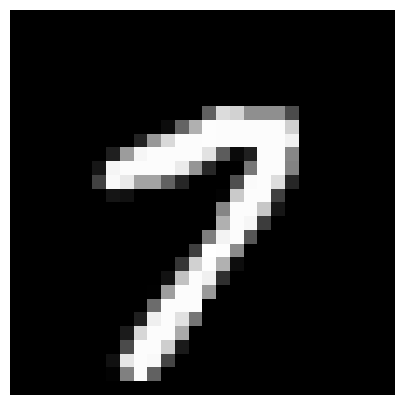

In [9]:
rnd_idx = np.random.randint(len(y_test))
print(f'La imagen muestreada representa un: {y_test[rnd_idx, 0]}')
plot_number(x_test_num[rnd_idx])

### Equations


$$z^1 = W^1 X + b^1$$

$$a^1 = ReLU(z^1) $$

$$z^2 = W^2 a^1 + b^2$$

$$\hat{y} = \frac{e^{z^{2_k}}}{\sum_j{e^{z_j}}}$$


$$ \mathcal{L}(\hat{y}^{i}, y^{i}) =  - y^{i}  \ln(\hat{y}^{i}) = -\ln(\hat{y}^i)$$


$$ \mathcal{J}(w, b) =  \frac{1}{num\_samples} \sum_{i=1}^{num\_samples}-\ln(\hat{y}^{i})$$

### Helper functions

#### Creat Mini batches

In [10]:
def create_minibatches(mb_size, x, y, shuffle = True):
    '''
    x  #muestras, 784
    y #muestras, 1
    '''
    assert x.shape[0] == y.shape[0], 'Error en cantidad de muestras'
    total_data = x.shape[0]
    if shuffle: 
        idxs = np.arange(total_data)
        np.random.shuffle(idxs)
        x = x[idxs]
        y = y[idxs]  
    return ((x[i:i+mb_size], y[i:i+mb_size]) for i in range(0, total_data, mb_size))

## Nuestra clase Linear, ReLU y Sequential

In [11]:
class np_tensor(np.ndarray): pass

In [12]:
a = np.array([0, 0])
b = a.view(np_tensor)

In [13]:
type(a)

numpy.ndarray

In [14]:
type(b)

__main__.np_tensor

In [15]:
a == b

np_tensor([ True,  True])

In [16]:
a is b

False

###  Clase Linear

In [17]:
class Linear():
    def __init__(self, input_size, output_size):
        '''
        Init parameters utilizando Kaiming He
        '''
        self.W = (np.random.randn(output_size, input_size) / np.sqrt(input_size/2)).view(np_tensor)
        self.b = (np.zeros((output_size, 1))).view(np_tensor)
    def __call__(self, X): # esta el foward de la clase lineal
        Z = self.W @ X + self.b
        return Z
    def backward(self, X, Z):
        X.grad = self.W.T @ Z.grad
        self.W.grad = Z.grad @ X.T
        self.b.grad = np.sum(Z.grad, axis = 1, keepdims=True)    
    

### Clase ReLU

In [18]:
class ReLU():
    def __call__(self, Z):
        return np.maximum(0, Z)
    def backward(self, Z, A):
        Z.grad = A.grad.copy()
        Z.grad[Z <= 0] = 0

### Clase Sequential

In [19]:
class Sequential_layers():
    def __init__(self, layers):
        '''
        layers - lista que contiene objetos de tipo Linear, ReLU
        '''
        self.layers = layers
        self.x = None
        self.outputs = {}
    def __call__(self, X):
        self.x = X 
        self.outputs['l0'] = self.x
        for i, layer in enumerate(self.layers, 1):
            self.x = layer(self.x)
            self.outputs['l'+str(i)]=self.x
        return self.x
    def backward(self):
        for i in reversed(range(len(self.layers))):
            self.layers[i].backward(self.outputs['l'+str(i)], self.outputs['l'+str(i+1)])
    def update(self, learning_rate = 1e-3):
        for layer in self.layers:
            if isinstance(layer, ReLU): continue
            layer.W = layer.W - learning_rate * layer.W.grad
            layer.b = layer.b - learning_rate * layer.b.grad
    def predict(self, X):
        return np.argmax(self.__call__(X))            

### Cost Function

In [20]:
def softmaxXEntropy(x, y):
    batch_size = x.shape[1]
    exp_scores = np.exp(x)
    probs = exp_scores / exp_scores.sum(axis = 0)
    preds = probs.copy()
    # Costo
    y_hat = probs[y.squeeze(), np.arange(batch_size)]
    cost = np.sum(-np.log(y_hat)) / batch_size
    # Calcular gradientes
    probs[y.squeeze(), np.arange(batch_size)] -= 1 #dl/dx
    x.grad = probs.copy()
    
    return preds, cost

### Loop de entrenamiento

In [21]:
def train(model, epochs, mb_size=128, learning_rate = 1e-3):
    for epoch in range(epochs):
        for i, (x, y) in enumerate(create_minibatches(mb_size, x_train, y_train)):
            scores = model(x.T.view(np_tensor))
            _, cost = softmaxXEntropy(scores, y)
            model.backward()
            model.update(learning_rate)
        print(f'costo: {cost}, accuracy: {accuracy(x_val, y_val, mb_size)}')

In [22]:
def accuracy(x, y, mb_size):
    correct = 0
    total = 0
    for i, (x, y) in enumerate(create_minibatches(mb_size, x, y)):
        pred = model(x.T.view(np_tensor))
        correct += np.sum(np.argmax(pred, axis=0) == y.squeeze())
        total += pred.shape[1]
    return correct/total

In [23]:
model = Sequential_layers([Linear(784, 200), ReLU(), Linear(200, 200), ReLU(), Linear(200, 10)])
mb_size = 512
learning_rate = 1e-4
epochs = 20


In [24]:
train(model, epochs, mb_size, learning_rate)

costo: 0.4325554171826368, accuracy: 0.9154
costo: 0.16853925807027434, accuracy: 0.9357
costo: 0.17690494905210313, accuracy: 0.9441
costo: 0.14840158101654652, accuracy: 0.9504
costo: 0.16908247536734636, accuracy: 0.9544
costo: 0.14697598427213213, accuracy: 0.9577
costo: 0.13467728842483023, accuracy: 0.9596
costo: 0.10904123878811182, accuracy: 0.9627
costo: 0.1021768647251571, accuracy: 0.9633
costo: 0.11274918547671191, accuracy: 0.9661
costo: 0.15502223766100925, accuracy: 0.965
costo: 0.09458714514145705, accuracy: 0.9647
costo: 0.08798403976400693, accuracy: 0.9687
costo: 0.11792384936657023, accuracy: 0.9682
costo: 0.07568680699791612, accuracy: 0.9716
costo: 0.04712214099585883, accuracy: 0.9697
costo: 0.05772234757917509, accuracy: 0.9712
costo: 0.06979646513382406, accuracy: 0.9717
costo: 0.05784291081945282, accuracy: 0.9723
costo: 0.048704686807272454, accuracy: 0.9713


In [25]:
print(accuracy(x_test, y_test, mb_size))

0.9712


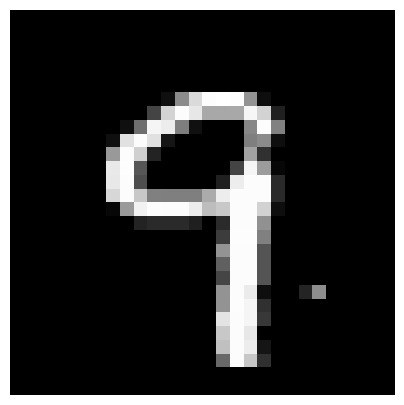

el valor predicho es: 9, el valor real es:9


In [26]:
idx = np.random.randint(len(y_test))
plot_number(x_test_num[idx])
pred = model.predict(x_test[idx].reshape(-1, 1))
print(f'el valor predicho es: {pred}, el valor real es:{y_test[idx][0]}')